# product_imageのノイズないほうが分類が良い

# 以下はラズパイのコード

In [1]:
from keras.preprocessing import image
from keras.models import load_model
from keras.preprocessing.image import img_to_array
# import pygame.mixer
import numpy as np
import matplotlib.pyplot as plt
# import picamera
from PIL import Image
import os
from time import sleep

Using TensorFlow backend.


# 有安コード（物体検出）

In [30]:
############ 物体検出 ############
from sklearn.cluster import KMeans
import cv2
def get_x_y_limit(Y, X, result, cluster):
    NO = np.where(result==cluster)
    x_max = np.max(X[NO])
    x_min = np.min(X[NO])
    y_max = np.max(Y[NO])
    y_min = np.min(Y[NO])
    x_max = int(x_max)
    x_min = int(x_min)
    y_max = int(y_max)
    y_min = int(y_min)
    return x_min, y_min, x_max, y_max
def bounding_box(img, x_min, y_min, x_max, y_max):
    img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 5)
    truncated = img[y_min:y_max, x_min:x_max]
    return img, truncated
def objection_detect(background_image, product_image):
    product_image = cv2.GaussianBlur(product_image, (5, 5), 0)    # ノイズなし？
    fgbg = cv2.bgsegm.createBackgroundSubtractorMOG()
    fgmask = fgbg.apply(np.uint8(background_image))
    fgmask = fgbg.apply(np.uint8(product_image))
    Y, X = np.where(fgmask > 200)
    y = KMeans(n_clusters=1, random_state=0).fit_predict(np.array([X,Y]).T)
    x_min, y_min, x_max, y_max = get_x_y_limit(Y, X, y, 0)
    return bounding_box(product_image, x_min, y_min, x_max, y_max)
background_image = cv2.imread("../../../../../Downloads/tes.jpeg") # パスだけ差し替え予定
background_image = cv2.GaussianBlur(background_image, (5, 5), 0)
##################################

# 柴田コード（分類）

In [15]:
############ 商品分類（柴田） ############
# テンプレート画像読み込み
path = "./example_pet-bottle-pic/temp"    # パスだけ差し替え予定
temp_files = os.listdir(path)
temp_files = [files for files in temp_files if files.endswith("png")]
temp_data = []
for n, data in enumerate(temp_files):
    temp = cv2.imread(path + "/" + data)
    temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
    temp_data.append(temp)
    
# 画像分類
def classfiler(img, param=0.59, num=6):    # パラメータ調整必要
    """
    SIFTを用いた画像分類
    パラメーターとして以下を調整
    param：最も近い点と2番目に近い点の距離の比率。
    num：マッチした特徴点の数の下限
    """
    # 画像マッチング
    for temp, temp_file in zip(temp_data, temp_files):
        #特徴抽出機の生成
        detector = cv2.xfeatures2d.SIFT_create()
        #kpは特徴的な点の位置 destは特徴を現すベクトル
        kp1, des1 = detector.detectAndCompute(temp, None)
        kp2, des2 = detector.detectAndCompute(img, None)
        #特徴点の比較機
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des1,des2, k=2)
        #割合試験を適用(２番目との差を param)
        good = []
        match_param = param
        for m,n in matches:
            if m.distance < match_param*n.distance:
                good.append([m])
        # good特徴点 num 個以上でマッチしたとする
        if len(good)>num:
            name = temp_file.strip(".png'")    # 拡張子に合わせる
            return name
##################################

In [16]:
# photo_filename = '/tmp/data.jpg'

# def shutter():
#     photofile = open(photo_filename, 'wb')
#     print(photofile)

#     # pi camera 用のライブラリーを使用して、画像を取得
#     with picamera.PiCamera() as camera:
#         #camera.resolution = (640,480)
#         camera.resolution = (300,400)
#         camera.start_preview()
#         sleep(1.000)
#         camera.capture(photofile)

# if __name__ == '__main__':
#     # モデル+重みを読込み
#     #self_model = load_model('MobileNet_auto_fine3_150_3.h5')
#     self_model = load_model('MobileNet_shape224.h5')
    
#     # 音声ファイル初期化
#     pygame.mixer.init()
#     pygame.mixer.music.load("Cash_Register-Beep01-1.mp3")

#     # 正解ラベル
#     label = ['cocacola-peach', 'ilohas', 'kuchidoke-momo', 'o-iocha', 'pocari-sweat']
#     # 商品価格
#     money = {'cocacola-peach':110, 'ilohas':120, 'kuchidoke-momo':130, 'o-iocha':140, 'pocari-sweat':150}

In [17]:
# # 正解ラベル
# label = ['maxコーヒー', 'カルピス', 'ジンジャエール', 'ファンタオレンジ', '三ツ矢サイダー']
# # 商品価格
# money = {'maxコーヒー':110, 'カルピス':120, 'ジンジャエール':130, 'ファンタオレンジ':140, '三ツ矢サイダー':150}
# # バックグラウンド
# background_image = np.full((224, 224, 3), 255)    # 実地では不要

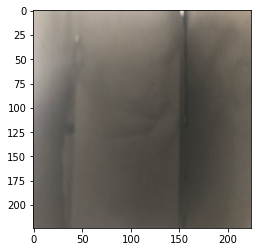

In [18]:
# バックグラウンド
background_image = cv2.imread("example_pet-bottle-pic/background/IMG_4850.JPG")
background_image = cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB)
background_image = cv2.resize(background_image, dsize=(224, 224))
plt.imshow(background_image)
plt.show()

In [19]:
# 正解ラベル
label = ['CCレモン', 'アクエリアス', 'ジャスミンティー', 'ジョージアブラック', 'ペプシ', 'ヘルシールイボスティー', '生茶', '北海道の強炭酸水']
# 商品価格
money = {'CCレモン':100, 'アクエリアス':110, 'ジャスミンティー':120, 'ジョージアブラック':130,
         'ペプシ':140, 'ヘルシールイボスティー':150, '生茶':160, '北海道の強炭酸水':170}

In [20]:
temp_files

['ジャスミンティー.png',
 '生茶.png',
 'CCレモン.png',
 'アクエリアス.png',
 '北海道の強炭酸水.png',
 'ペプシ.png',
 'ヘルシールイボスティー.png',
 'ジョージアブラック.png']

In [27]:
# 画像分類
while True:
        money_sum = 0 
        key = input('商品をスキャンする場合は「Enter」を押して下さい')
        while True:
            # 画像の取得
#             shutter()

#             # 音声再生
#             pygame.mixer.music.play(1)
#             sleep(1)
#             # 再生の終了
#             pygame.mixer.music.stop()
            
            ############ 画像の調整、ボックス取得（柴田） ############
            # 画像をモデルの入力用に加工
#             img = Image.open(photo_filename)
            
            # テスト用（上記カメラ画像の代わり）
            path = input('検出画像のパスを入力してください')
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, dsize=(224, 224))
            background_image = cv2.resize(background_image, dsize=(224, 224))
            # imgはbox付きの元画像、truncatedは切り取った画像
#             img, truncated = objection_detect(img, product_image) 
            img, truncated = objection_detect(background_image, img)    # 一行上のコードから変数名変更（これじゃないと動かない）
#             img = img.resize((224, 224))
            
#             img_array = img_to_array(img)
#             img_array = img_array.astype('float32')/255.0
#             img_array = img_array.reshape((1,224,224,3))
            #######################################

            
            # predict
#             img_pred = self_model.predict(img_array)
#             print("debug:",img_pred)
#             name = label[np.argmax(img_pred)]
            
            ############ 分類、登録商品とそれ以外で分けてる（柴田） ############
            # truncatedを使用して分類、224へのリサイズ不要
            name = classfiler(truncated, param=0.59, num=6)    # パラメータ調整必要
            if not name:
                print("登録書品ではありません")
            else:
                print(name)
                money_sum += money[name]
                print("小計",money_sum)
            key = input('続けて商品をスキャンする場合は「y」,会計する場合は「Enter」を押して下さい')
            if key != 'y':
                print("合計:{}円".format(money_sum))
                break

商品をスキャンする場合は「Enter」を押して下さい
検出画像のパスを入力してくださいexample_pet-bottle-pic/image10.jpg
ジャスミンティー
小計 120
続けて商品をスキャンする場合は「y」,会計する場合は「Enter」を押して下さいy
検出画像のパスを入力してくださいexample_pet-bottle-pic/image16.jpg
登録書品ではありません
続けて商品をスキャンする場合は「y」,会計する場合は「Enter」を押して下さいy
検出画像のパスを入力してくださいexample_pet-bottle-pic/image15.jpg
ヘルシールイボスティー
小計 270
続けて商品をスキャンする場合は「y」,会計する場合は「Enter」を押して下さいy
検出画像のパスを入力してくださいexample_pet-bottle-pic/image20.jpg
登録書品ではありません
続けて商品をスキャンする場合は「y」,会計する場合は「Enter」を押して下さいy
検出画像のパスを入力してくださいexample_pet-bottle-pic/image21.jpg
登録書品ではありません
続けて商品をスキャンする場合は「y」,会計する場合は「Enter」を押して下さいy
検出画像のパスを入力してくださいexample_pet-bottle-pic/image22.jpg
登録書品ではありません
続けて商品をスキャンする場合は「y」,会計する場合は「Enter」を押して下さいy
検出画像のパスを入力してくださいexample_pet-bottle-pic/image23.jpg
登録書品ではありません
続けて商品をスキャンする場合は「y」,会計する場合は「Enter」を押して下さいy
検出画像のパスを入力してくださいexample_pet-bottle-pic/image24.jpg
登録書品ではありません
続けて商品をスキャンする場合は「y」,会計する場合は「Enter」を押して下さいy
検出画像のパスを入力してくださいexample_pet-bottle-pic/image25.jpg
登録書品ではありません
続けて商品をスキャンする場合は「y」,会計する場合は「Enter」を押して下さい
合計:270円
商品をスキャンす

error: OpenCV(3.4.2) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/color.hpp:253: error: (-215:Assertion failed) VScn::contains(scn) && VDcn::contains(dcn) && VDepth::contains(depth) in function 'CvtHelper'
